In [1]:
# the purpose of this test is to check if the 2D kernel can learn to generate pattern present in the training data
# step 1. test of data with same attributes with the same length
# step 2  test of data with same attributes with the different length
# step 3. test with different attributes  and different length

# data generation
import torch
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplot
import math
from torch_geometric.data import Data
import numpy as np



def color_for_element(atomic_num):
    color ='lightgrey'
    if(atomic_num == 1):
        color = 'lightgrey'
    elif(atomic_num ==6):
        color = 'black'
    elif(atomic_num ==8):
        color = 'red'
    elif(atomic_num ==7):
        color = 'blue'
    elif(atomic_num ==16):
        color = 'yellow'
    return color

def linestyle_for_bond_type(edge_attr):
    linestyle='-'
    if(edge_attr == 2):
        linestyle='--'
    elif(edge_attr==3):
        linestyle=':'
    elif(edge_attr==4):
        linestyle='-.'
    return linestyle

def angle_between_two_vectors(vector_1, vector_2):

#     print('\n')
#     print('vector1:')
#     print(vector_1)
#     print('vector2:')
#     print(vector_2)
    if torch.all(torch.eq(vector_1,vector_2)):
        return None
    
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
#     print('norm vector1:')
#     print(unit_vector_1)
    
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
#     print('norm vector2:')
#     print(unit_vector_2)
    
    dot_product = np.dot(unit_vector_1, unit_vector_2)
#     print(f'dot:{dot_product}')
    angle = np.arccos(dot_product)
    angle = angle/math.pi *180
    return angle

def edge_length(vector):
    return np.linalg.norm(vector)
    

def vis(data = None, x_neighbor = None, x_focal = None, p_neighbor=None, p_focal=None, edge_attr_neighbor = None, vis_kernel=False):
    fig_size = 5
    marker_size = 500
    lower_bound = -1.5
    upper_bound = 2
    
#     if(vis_kernel ==False):
    plt.figure(figsize = (fig_size,fig_size))
    plt.xlim(lower_bound,upper_bound)
    plt.ylim(lower_bound,upper_bound)


    if data is not None:
        try:
            p_neighbor = data.p_neighbor
            p_focal = data.p_focal

        except:
            raise Exception('In data, either center position p_focal or position p is not provided')
                  
        try:
            x_neighbor = data.x_neighbor
        except:
            x_neighbor = None
        try:
            x_focal = data.x_focal
        except:
            x_focal = None
        try:
            edge_attr_neighbor = data.edge_attr_neighbor
        except:
            edge_attr_neighbor = None
    else:
        if p_neighbor is None or p_focal is None:
            raise Exception('either provide data, or provide both p_neighbor and p_focal is provided')
    
    if(vis_kernel==False):
        print('====data info====')

        print('p_neighbor:')
        print(p_neighbor)

        if x_neighbor is not None:
            print('\n')
            print('x_neighbor:')
            print(x_neighbor)

        if x_focal is not None:
            print('\n')
            print('x_focal:')
            print(x_focal)

        if p_focal is not None:
            print('\n')
            print('p_focal:')
            print(p_focal)

        if edge_attr_neighbor is not None:
            print('\n')
            print('edge_attr_neighbor:')
            print(edge_attr_neighbor)
    
    
    print('\n')
    s = p_neighbor.shape[0]
    calibrated_p_neighbor = p_neighbor-p_focal
    for i in range(s):
        for j in range(i):
            angle = angle_between_two_vectors(calibrated_p_neighbor[i], calibrated_p_neighbor[j])
            if (angle is not None):
                print(f'{i}-{j} angle:{angle}')
    print('\n')
    
    for i in range(s):
        print(f'{i} length:{edge_length(calibrated_p_neighbor[i])}')
        
    print('=========')

    # annotate and color
    for i in range(p_neighbor.shape[0]):
        if x_neighbor is None or ( vis_kernel == True):
            plt.annotate(i, (p_neighbor[i,:]))
            color = 'blue'
        else:
            pt = Chem.GetPeriodicTable() 
            atomic_num = int(x_neighbor[i,0].item())
            plt.annotate(pt.GetElementSymbol(atomic_num),(p_neighbor[i,:]))
            marker_size = x_neighbor[i,2].item()*500
            color = color_for_element(atomic_num)
            
        # draw neighors
        plt.scatter(p_neighbor[i,0], p_neighbor[i,1], color = color, s = marker_size, alpha = 0.5)
        
    # draw focal    
    plt.scatter(p_focal[0], p_focal[1], color = 'dimgrey', s= marker_size)
    
    # draw bonds
    for each_p_neighbor in p_neighbor:
        plt.plot([each_p_neighbor[0], p_focal[0]],[each_p_neighbor[1],p_focal[1]], color = 'black')
    plt.show()    

def get_kernel_from_model(model):
    params = model.state_dict()
#     for param in params:
#         print(param)
    
    num_kernel_sets = int(len(params)/4)
#     print(f'num_kernel_sets:{num_kernel_sets}')
    
    kernel_list = []
    for i in range(num_kernel_sets):

        x_center_array = params[f'kernel_set.{i}.x_center']
        x_support_array = params[f'kernel_set.{i}.x_support']
        edge_attr_support_array = params[f'kernel_set.{i}.edge_attr_support']
        p_support_array = params[f'kernel_set.{i}.p_support']
        output_kernel = Data(p_support = torch.tensor(p_support_array), x_support = torch.tensor(x_support_array), x_center = torch.tensor(x_center_array), edge_attr_support = torch.tensor(edge_attr_support_array))
        kernel_list.append(output_kernel)
    return kernel_list


def vis_kernel(kernel):
    kernel_list=[]
    if isinstance(kernel, Data):
        kernel_list = [kernel]
    else:
        kernel_list = kernel
    
    for kernel in kernel_list:
        num_sets = kernel.x_support.shape[0]

        for l in range(num_sets):
            kernel.x_neighbor = kernel.x_support[l, :,:]

            kernel.p_neighbor = kernel.p_support[l,:,:]

            kernel.x_focal = kernel.x_center[l,:,:]

            p_center = torch.tensor([0,0])    
            kernel.p_focal = p_center

            kernel.edge_attr_neighbor = kernel.edge_attr_support[l, :,:]

#             subplot(num_sets,4,l+1)
            vis(kernel, vis_kernel=True)

            print(f'===={l}th kernel info====')
    
            
            print(f'{l}th-p_support:')
            print(kernel.p_neighbor.shape)

            if x is not None:
                print('\n')
                print(f'{l}th-x_support:')
                print(kernel.x_neighbor.shape)

            if x_focal is not None:
                print('\n')
                print(f'{l}th-x_center:')
                print(kernel.x_focal.shape)

            if p_focal is not None:
                print('\n')
                print(f'{l}th-p_center:')
                print(kernel.p_focal.shape)

            if edge_attr is not None:
                print('\n')
                print(f'{l}th-edge_attr_support:')
                print(kernel.edge_attr_neighbor.shape)
            
        
def vis_graph(data, lower_bound = -4, upper_bound = 5):
    fig_size = 5
    marker_size = 500

    
    plt.figure(figsize = (fig_size,fig_size))
    plt.xlim(lower_bound,upper_bound)
    plt.ylim(lower_bound,upper_bound)
    
    
    x = data.x
    p = data.p
    edge_index = data.edge_index
    edge_attr = data.edge_attr
    
    for i in range(x.shape[0]):
        pt = Chem.GetPeriodicTable() 
        atomic_num = int(x[i,0].item())
        color = color_for_element(atomic_num)
        plt.scatter(p[i,0], p[i,1], color = color, s = marker_size, alpha = 0.5)
    

    for col in range(edge_index.shape[1]):
        start_idx = edge_index[0,col]
        end_idx = edge_index[1,col]
#         print(f'start_idx:{start_idx}, end_idx:{end_idx}')
        linestyle = linestyle_for_bond_type(edge_attr[col])       
        plt.plot([p[start_idx][0], p[end_idx][0]],  [p[start_idx][1],p[end_idx][1]], color = 'black', linestyle = linestyle)
    
#     legend = plt.legend(handles=['--'], labels=["red dotted line"], handlelength=5)

    
def vis_kernel_in_model(model):
    kernel = get_kernel_from_model(model)
    if isinstance(kernel, Data):
        print(f'kernel:{kernel}')
        
    else:
        pass
        print('kernels:')
        for k in kernel:
            print(k)
    vis_kernel(kernel)

    
def rotate(p_center, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given p_center.

    The angle should be given in degrees.
    """
    angle = angle * math.pi/180
    
    ox, oy = p_center
#     print(f'ox:{ox}, oy:{oy}')
    px, py = point
#     print(f'px:{px}, py:{py}')
    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return torch.tensor([qx, qy])

def tensor_rotate(p_center, points, angle):
    l = []
    for point in points:
        new_p = rotate(p_center, point, angle)
        l.append(new_p)
    l = torch.stack(l, dim=0)
#     print(f'f:{l.shape}')
    return torch.tensor(l)

def graph_rotate(data, p_center, angle):
    p = data.p
    new_p = tensor_rotate(p_center, p, angle)
    new_data = data.clone()
    new_data.p = new_p
    return new_data

# new_p = tensor_rotate(p_center, p, 180)
# # print(new_p)
# # vis(new_p, p_center)

# data_list = []
# for i in range(0, 370, 10):
#     new_p = tensor_rotate(p_center, p, i)
#     data = Data(p = new_p, p_center = p_center)
#     data_list.append(data)

# # for data in data_list:
# #     vis(data, p_center)


# translate
trans = torch.tensor([[1,1]])

# S = 3
x_support = torch.tensor([[1],[1],[1]], dtype = torch.float)
p_support = torch.tensor([[-1,0],[-math.sqrt(0.5),math.sqrt(0.5)],[0,1]], dtype = torch.float)
p_support+=trans
p_center = torch.tensor([0,0]) + trans.squeeze(dim =0)


#S = 4
# data
# x = torch.tensor([[1],[1],[1],[1]], dtype = torch.float)
# p = torch.tensor([[-1,0],[-math.sqrt(0.5),math.sqrt(0.5)],[0,1], [math.sqrt(0.5), math.sqrt(0.5)]], dtype = torch.float)


# vis(p_neighbor = p_support, p_focal = p_center)
# model = KernelSetConv(L = 10, D=2, node_attr_dim = 5, edge_attr_dim =1)
# vis_kernel_in_model(model)

D:\Anaconda3\envs\conv_qsar\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\envs\conv_qsar\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\envs\conv_qsar\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\envs\conv_qsar\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWa

calculating rdkit element representation lookup table
====data info====
p_neighbor:
tensor([[ 1.2990e+00,  7.5000e-01],
        [-1.2990e+00,  7.5000e-01],
        [-2.7756e-16, -1.5000e+00]])


x_neighbor:
tensor([[ 8.0000, 15.9990,  1.5500,  2.0000,  6.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


x_focal:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


p_focal:
tensor([-5.5511e-17, -5.5511e-17])


edge_attr_neighbor:
tensor([[2],
        [1],
        [1]])


1-0 angle:120.00000333930423
2-0 angle:120.00000333930423
2-1 angle:120.00000333930423


0 length:1.5
1 length:1.5
2 length:1.5


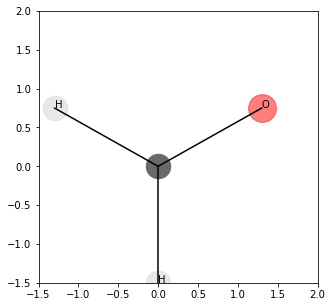

D:\Anaconda3\envs\conv_qsar\lib\site-packages\ipykernel_launcher.py:309: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[16, 32.067, 1.8, 2, 6]

In [20]:
# test of p with different attributes
from rdkit import Chem
from rdkit.Chem import AllChem
import rdkit
import torch
from torch_geometric.data import Data

elements = ['H', 'C', 'N', 'O', 'P', 'S', 'F', 'Cl', 'Br', 'I']
elem_lst =None


def lookup_from_rdkit(elements):
    global elem_lst

    if elem_lst is None:
        print('calculating rdkit element representation lookup table')
        elem_rep_lookup = []
        for elem in elements:
            pt = Chem.GetPeriodicTable() 

            if isinstance(elem, int):
                num=elem
                sym=pt.GetElementSymbol(num)
            else:
                num = pt.GetAtomicNumber(elem)
                sym = elem
            w = pt.GetAtomicWeight(elem)

            Rvdw = pt.GetRvdw(elem)
        #     Rcoval = pt.GetRCovalent(elem)
            valence = pt.GetDefaultValence(elem)
            outer_elec = pt.GetNOuterElecs(elem)

            elem_rep=[num, w,  Rvdw, valence, outer_elec]
#             print(elem_rep)


            elem_rep_lookup.append(elem_rep)
        elem_lst = elem_rep_lookup.copy()
        return elem_rep_lookup
    else:
        return elem_lst




def get_atom_rep(atomic_num, package='rdkit'):
    '''use rdkit or pymatgen to generate atom representation
    '''
    max_elem_num = 118
    element_nums= [x+1 for x in range(max_elem_num)]


    if package =='rdkit':
        elem_lst = lookup_from_rdkit(element_nums)
    elif package == 'pymatgen':
        raise Exception('pymatgen implementation is deprecated.')
        #elem_lst = lookup_from_pymatgen(element_nums)
    else:
        raise Exception('cannot generate atom representation lookup table')

    result = 0
    try:
        result = elem_lst[atomic_num - 1]
    except:
        print(f'error: atomic_num {atomic_num} does not exist')

    return result


def smiles2graph(D, smiles):
    if D==None:
        raise Exception('smiles2grpah() needs to input D to specifiy 2D or 3D graph generation.')
    
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    
    if D==2:
        rdkit.Chem.rdDepictor.Compute2DCoords(mol)
    if D==3:
        AllChem.EmbedMolecule(mol)
        AllChem.UFFOptimizeMolecule(mol)
    
    conf = mol.GetConformer()
    
    atom_pos = []
    atom_attr =[]
    
    # get atom attributes and positions
    for i, atom in enumerate(mol.GetAtoms()):
        atomic_num = atom.GetAtomicNum()
        h = get_atom_rep(atomic_num)
    
        atom_pos.append([conf.GetAtomPosition(i).x, conf.GetAtomPosition(i).y])#, conf.GetAtomPosition(i).z])
        atom_attr.append(h)
    
    # get bond attributes
    edge_list = []
    edge_attr_list =[]
    for idx, edge in enumerate(mol.GetBonds()):
        i = edge.GetBeginAtomIdx()
        j = edge.GetEndAtomIdx()
        
        bond_attr = None
        bond_type = edge.GetBondType()
        if bond_type ==Chem.rdchem.BondType.SINGLE:
            bond_attr = [1]
        elif bond_type ==Chem.rdchem.BondType.DOUBLE:
            bond_attr = [2]
        elif bond_type ==Chem.rdchem.BondType.TRIPLE:
            bond_attr = [3]
        elif bond_type ==Chem.rdchem.BondType.AROMATIC:
            bond_attr = [4]     
            

        edge_list.append((i, j))
        edge_attr_list.append(bond_attr) 
#         print(f'i:{i} j:{j} bond_attr:{bond_attr}')

        edge_list.append((j, i))
        edge_attr_list.append(bond_attr)    
#         print(f'j:{j} j:{i} bond_attr:{bond_attr}')    
    
    x = torch.tensor(atom_attr)
    p = torch.tensor(atom_pos)
    edge_index = torch.tensor(edge_list).t().contiguous()
    edge_attr = torch.tensor(edge_attr_list)
        
    return x, p, edge_index, edge_attr

smiles = 'C(=O)([H])[H]'
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)

# for 3D
# AllChem.EmbedMolecule(mol)
# AllChem.UFFOptimizeMolecule(mol)
# conf = mol.GetConformer()


# for 2D
rdkit.Chem.rdDepictor.Compute2DCoords(mol)
conf = mol.GetConformer()
atom_pos = []
atom_attr =[]
x_focal = None
for i, atom in enumerate(mol.GetAtoms()):
    atomic_num = atom.GetAtomicNum()
    h = get_atom_rep(atomic_num, 'rdkit')
    if atomic_num == 6:
        p_focal = torch.tensor([conf.GetAtomPosition(i).x, conf.GetAtomPosition(i).y])#, conf.GetAtomPosition(i).z ])
        x_focal = torch.tensor(h)
    else:
        atom_pos.append([conf.GetAtomPosition(i).x, conf.GetAtomPosition(i).y])#, conf.GetAtomPosition(i).z])
        atom_attr.append(h)
        
edge_attr = []
for j, edge in enumerate(mol.GetBonds()):
    bond_type = edge.GetBondType()
    if bond_type ==Chem.rdchem.BondType.SINGLE:
        edge_attr.append(1)
    elif bond_type ==Chem.rdchem.BondType.DOUBLE:
        edge_attr.append(2)
    elif bond_type ==Chem.rdchem.BondType.TRIPLE:
        edge_attr.append(3)
    elif bond_type ==Chem.rdchem.BondType.AROMATIC:
        edge_attr.append(4)
edge_attr_neighbor = torch.tensor(edge_attr).unsqueeze(0).T
                              
p_neighbor = torch.tensor(atom_pos)
x_neighbor = torch.tensor(atom_attr)                              
x_focal = x_focal.unsqueeze(0)
# print(p)
# print(origin)
# print(x)
  
    
#============generate a list of same receptive field 
data = Data(p_neighbor=p_neighbor, x_neighbor=x_neighbor, x_focal=x_focal, edge_attr_neighbor=edge_attr_neighbor, p_focal=p_focal)
# print(data)
vis(data=data)

data_list = []
for i in range(0, 370, 10):
    new_p = tensor_rotate(p_focal, p_neighbor, i)
    data = Data(p = new_p, p_focal = p_focal, x_neighbor=x_neighbor, x_focal = x_focal, edge_attr = edge_attr)
    data_list.append(data)
#     vis(data=data)







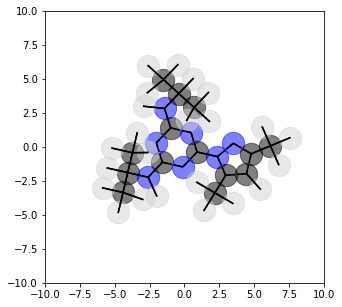

In [3]:
x =torch.tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 7.0000, 14.0070,  1.6000,  3.0000,  5.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 7.0000, 14.0070,  1.6000,  3.0000,  5.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 7.0000, 14.0070,  1.6000,  3.0000,  5.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 7.0000, 14.0070,  1.6000,  3.0000,  5.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 7.0000, 14.0070,  1.6000,  3.0000,  5.0000],                                                                                                                                                                     [ 7.0000, 14.0070,  1.6000,  3.0000,  5.0000],                                                                                                                                                                     [ 7.0000, 14.0070,  1.6000,  3.0000,  5.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])  
p = torch.tensor([[-3.7256, -0.4303],                                                                                                                                                                                                [-4.0641, -1.8916],                                                                                                                                                                                                [-4.4027, -3.3529],                                                                                                                                                                                                [-2.6028, -2.2302],                                                                                                                                                                                                [-1.5790, -1.1339],                                                                                                                                                                                                [-2.0164,  0.3008],                                                                                                                                                                                                [-0.9926,  1.3971],                                                                                                                                                                                                [-1.4300,  2.8319],                                                                                                                                                                                                [-0.4062,  3.9281],                                                                                                                                                                                                [ 0.6900,  2.9043],                                                                                                                                                                                                [-1.5024,  4.9520],                                                                                                                                                                                                [ 0.4687,  1.0585],                                                                                                                                                                                                [ 0.9062, -0.3763],                                                                                                                                                                                                [-0.1177, -1.4725],                                                                                                                                                                                                [ 2.3675, -0.7148],                                                                                                                                                                                                [ 3.5003,  0.2684],                                                                                                                                                                                                [ 4.7854, -0.5051],                                                                                                                                                                                                [ 6.1666,  0.0799],                                                                                                                                                                                                [ 4.4469, -1.9664],                                                                                                                                                                                                [ 2.9525, -2.0960],                                                                                                                                                                                                [ 2.1789, -3.3812],                                                                                                                                                                                                [-3.3870,  1.0310],                                                                                                                                                                                                [-2.6322, -0.4120],                                                                                                                                                                                                [-5.1869, -0.0918],                                                                                                                                                                                                [-5.5254, -1.5531],                                                                                                                                                                                                [-4.7412, -4.8142],                                                                                                                                                                                                [-5.8640, -3.0144],                                                                                                                                                                                                [-2.9935, -3.8671],                                                                                                                                                                                                [-1.9937, -3.6010],                                                                                                                                                                                                [-2.9217,  2.9898],                                                                                                                                                                                                [ 0.6176,  5.0244],                                                                                                                                                                                                [ 1.7863,  1.8804],                                                                                                                                                                                                [ 1.7139,  4.0005],                                                                                                                                                                                                [ 0.1592,  1.9483],                                                                                                                                                                                                [-2.5987,  5.9758],                                                                                                                                                                                                [-0.4786,  6.0482],                                                                                                                                                                                                [-2.6523,  3.9887],                                                                                                                                                                                                [ 7.5479,  0.6649],                                                                                                                                                                                                [ 6.7517, -1.3013],                                                                                                                                                                                                [ 5.5816,  1.4611],                                                                                                                                                                                                [ 5.4301, -3.0993],                                                                                                                                                                                                [ 1.4054, -4.6663],                                                                                                                                                                                                [ 3.4641, -4.1547],                                                                                                                                                                                                [ 0.8938, -2.6076]])       
edge_index = torch.tensor([[ 0,  1,  1,  2,  1,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,                                                                                                                                             8, 10,  6, 11, 11, 12, 12, 13, 12, 14, 14, 15, 15, 16, 16, 17, 16, 18,                                                                                                                                            18, 19, 19, 20, 13,  4, 19, 14,  0, 21,  0, 22,  0, 23,  1, 24,  2, 25,                                                                                                                                             2, 26,  2, 27,  3, 28,  7, 29,  8, 30,  9, 31,  9, 32,  9, 33, 10, 34,                                                                                                                                            10, 35, 10, 36, 17, 37, 17, 38, 17, 39, 18, 40, 20, 41, 20, 42, 20, 43],                                                                                                                                          [ 1,  0,  2,  1,  3,  1,  4,  3,  5,  4,  6,  5,  7,  6,  8,  7,  9,  8,                                                                                                                                            10,  8, 11,  6, 12, 11, 13, 12, 14, 12, 15, 14, 16, 15, 17, 16, 18, 16,                                                                                                                                            19, 18, 20, 19,  4, 13, 14, 19, 21,  0, 22,  0, 23,  0, 24,  1, 25,  2,                                                                                                                                            26,  2, 27,  2, 28,  3, 29,  7, 30,  8, 31,  9, 32,  9, 33,  9, 34, 10,                                                                                                                                            35, 10, 36, 10, 37, 17, 38, 17, 39, 17, 40, 18, 41, 20, 42, 20, 43, 20]])  
edge_attr = torch.tensor([[1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1]])    
data = Data(x = x, p= p , edge_index= edge_index, edge_attr = edge_attr)
vis_graph(data, lower_bound = -10, upper_bound = 10)



Data(edge_attr=[16, 1], edge_index=[2, 16], p=[9, 2], x=[9, 5])
tensor([[[ 1.2990e+00,  7.5000e-01],
         [-1.2990e+00,  7.5000e-01],
         [-2.7756e-16, -1.5000e+00]]])
deg:1
num_focal:6
selected_index:torch.Size([6])
p_neighbor:torch.Size([6, 1, 2])
p_support:torch.Size([1, 1, 1, 2])
angle_sc:torch.Size([1, 1, 6])
best_angle_sc:torch.Size([1, 6])
best_angle_sc_index:torch.Size([1, 6])
permuted_p_support:torch.Size([1, 1, 6, 1, 2])
best_p_support:torch.Size([1, 6, 1, 2])
len_p_neighbor:torch.Size([6, 1])
len_p_support:torch.Size([1, 6, 1])
length_sc:torch.Size([1, 6])
permuted_x_support:torch.Size([1, 1, 1, 5])
supp_attr_sc:torch.Size([1, 6])
center_attr_sc:torch.Size([1, 6])
edge_attr_support_sc:torch.Size([1, 6])
len sc:tensor([[[1.1281, 1.1281, 1.1281, 1.1281, 1.1281, 1.1281]]],
       grad_fn=<UnsqueezeBackward0>)
angle sc:tensor([[[1.5708, 1.5708, 1.5708, 1.5708, 1.5708, 1.5708]]])
support attribute_sc:tensor([[[0.0036, 0.0036, 0.0036, 0.0036, 0.0036, 0.0036]]],
       gra

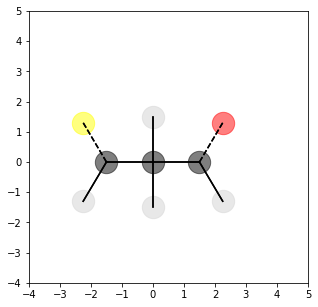

In [23]:
# # test of kernel with L

# from torch_geometric.nn import MessagePassing
# from torch_geometric.data import Data
# from torch_geometric.utils import degree

# import torch
# from torch.nn import ModuleList
# from torch.nn import CosineSimilarity, Module, ModuleList, Linear, Sigmoid
# from torch.nn.parameter import Parameter

# from itertools import permutations
# import math


# class KernelConv(Module):
#     def __init__(self, L=None, D=None, num_supports=None, node_attr_dim=None, edge_attr_dim=None, init_kernel: 'type(Data)'=None):
#         super(KernelConv, self).__init__()
#         if init_kernel is None:
#             if (L is None) or (D is None) or (num_supports is None) or (node_attr_dim is None) or (edge_attr_dim is None):
#                 raise Exception(
#                     'either numer of kernels L, convolution dimention D, number of support num_supports or feature dimension node_attr_dim is not specified')
#             else:
#                 init_kernel = Data(x_center=torch.randn(L, 1, node_attr_dim),  x_support=torch.randn(
#                     L, num_supports, node_attr_dim), edge_attr_support=torch.randn(L, num_supports, edge_attr_dim), p_support=torch.randn(L, num_supports, D))

#         x_center_tensor = init_kernel.x_center
#         self.x_center = Parameter(x_center_tensor)

#         x_support_tensor = init_kernel.x_support
#         self.x_support = Parameter(x_support_tensor)

#         edge_attr_support_tensor = init_kernel.edge_attr_support
#         self.edge_attr_support = Parameter(edge_attr_support_tensor)

#         p_support_tensor = init_kernel.p_support
# #         print(f'p_support_tensor:{p_support_tensor.shape}')
#         self.p_support = Parameter(p_support_tensor)

#     def permute(self, x):
#         #         print('permute')
#         #         print('x')
#         #         print(x.shape)
#         rows = x.shape[1]
#         l = [x[:, torch.tensor(permute), :]
#              for permute in list(permutations(range(rows)))]
#         output = torch.stack(l, dim=1)
# #         print('permuted')
# #         print(output.shape)
#         return output

#     def intra_angle(self, p):
#         '''
#         angles between each row vectors
#         '''
#         cos = CosineSimilarity(dim=-1)
#         new_p = torch.roll(p, 1, dims=-2)
# #         print(f'new p:')
# #         print(new_p)
#         sc = cos(new_p, p)
# #         print(f'intra angle sc:{sc.shape}')
#         return sc

#     def arctan_sc(self, tensor1, tensor2, dim=None):
#         diff = torch.square(tensor1 - tensor2)
# #         print(diff)
#         if dim is not None:
#             sc = torch.sum(diff, dim=dim)
#         else:
#             sc = torch.sum(diff)
#         sc = torch.atan(1 / sc)
#         return sc

#     def get_angle_score(self, p_neighbor, p_support):

#         #         p_neighbor = p_neighbor.unsqueeze(0).expand(p_support.shape[0], p_neighbor.shape[0],p_neighbor.shape[1],p_neighbor.shape[2])
#         #         p_support = p_support.unsqueeze(1).expand(p_support.shape[0],p_neighbor.shape[1],p_support.shape[1],p_support.shape[2])

#         #         print('get_angle_score')
#         print(f'p_neighbor:{p_neighbor.shape}')
#         #         print(p_neighbor.shape)
#         print(f'p_support:{p_support.shape}')
#         #         print(p_support.shape)
#         if(p_support.shape[2] == 1):
#             return torch.full((p_support.shape[0],1,  p_neighbor.shape[0]), math.pi / 2)
# #         cos = CosineSimilarity(dim = 1)

#         p_neighbor = p_neighbor.unsqueeze(0).unsqueeze(0).expand(
#             p_support.shape[0], p_support.shape[1], p_neighbor.shape[-3], p_neighbor.shape[-2], p_neighbor.shape[-1])
# #         p_neighbor = p_neighbor.unsqueeze(0).expand(p_support.shape)
# #         print(f'p_neighbor:{p_neighbor.shape}')
#         intra_p_neighbor_dist = self.intra_angle(p_neighbor)
# #         intra_p_neighbor_dist = intra_p_neighbor_dist.unsqueeze(0).expand(p_support.shape[0], p_neighbor.shape[0],p_neighbor.shape[1])
# #         print(f'intra_p_neighbor_dist:{intra_p_neighbor_dist.shape}')

#         p_support = p_support.unsqueeze(2).expand(p_neighbor.shape)
# #         print(f'p_support:{p_support.shape}')
#         intra_p_support_dist = self.intra_angle(p_support)
# #         intra_p_support_dist = intra_p_support_dist.unsqueeze(1).expand(p_support.shape[0], p_neighbor.shape[0],p_support.shape[1])
# #         print(f'intra_p_support_dist:{intra_p_support_dist.shape}')

# #         sc = cos(intra_p_neighbor_dist, intra_p_support_dist)
# #         sc = torch.dot(intra_p_neighbor_dist, intra_p_support_dist.T)
#         sc = self.arctan_sc(intra_p_neighbor_dist,
#                             intra_p_support_dist, dim=(-1))
# #         print(f'angle_sc:{sc}')
#         return sc

#     def get_length_score(self, p_neighbor, p_support):
#         len_p_neighbor = torch.norm(p_neighbor, dim=-1)
#         len_p_support = torch.norm(p_support, dim=-1)

# #         print('len_p_neighbor')
#         print(f'len_p_neighbor:{len_p_neighbor.shape}')
#         print(f'len_p_support:{len_p_support.shape}')

#         # inverse of L2 norm
#         sc = self.arctan_sc(len_p_neighbor, len_p_support, dim=(-1))
# #         diff = torch.square(len_p_neighbor - len_p_support)
# #         sc = torch.sum(diff)
# #         sc = torch.atan(1/sc)

# # #         print(sc)
#         return sc

#     def get_support_attribute_score(self, x_nei, x_support: 'shape(s, d)'):

#         # inverse of L2 norm
#         #         print('x_nei')
#         #         print(x_nei)
#         #         print('x_support')
#         #         print(x_support)
#         #         diff = torch.square(x_nei - x_support)
#         #         sc = torch.sum(diff)
#         #         sc:'shape([])' = torch.atan(1/sc)
#         sc = self.arctan_sc(x_nei, x_support, dim=(-2, -1))
#         return sc

#     def get_center_attribute_score(self, x_focal, x_center):
#         # inverse of L2 norm
#         #         print(f'center attri:{type(x_focal)}, {type(x_center)}')
#         #         print(f'x_focal:{x_focal.shape}, x_center:{x_center.shape}')
#         #         print(x_focal)
#         #         print(x_center)
#         #         diff = torch.square(x_focal - x_center)
#         #         sc = torch.sum(diff)
#         #         sc:'shape([])' = torch.atan(1/sc)
#         x_focal = x_focal.unsqueeze(0).expand(
#             x_center.shape[0], x_focal.shape[0], x_focal.shape[1])
#         x_center = x_center.expand(x_focal.shape)
#         sc = self.arctan_sc(x_focal, x_center, dim=(-1))
#         return sc

#     def get_edge_attribute_score(self, edge_attr_nei, edge_attr_support):
#         #         print('edge_attr_nei')
#         #         print(edge_attr_nei)
#         #         print('edge_attr_support')
#         #         print(edge_attr_support)
#         #         diff = torch.square(edge_attr_nei - edge_attr_support)
#         #         sc = torch.sum(diff)
#         #         sc:'shape([])' = torch.atan(1/sc)
#         sc = self.arctan_sc(edge_attr_nei, edge_attr_support, dim=( -2, -1))
#         return sc

#     def calculate_total_score(self, x_focal, p_focal, x_neighbor, p_neighbor, edge_attr_neighbor):
#         # calibrate p_neighbor
#         p_neighbor = p_neighbor - p_focal.unsqueeze(1)

#         # get kernel params
#         x_center = self.x_center
#         x_support = self.x_support
#         edge_attr_support = self.edge_attr_support
#         p_support = self.p_support

# #         print('=====cal total sc')
# #         print(f'x_center:{x_center.shape}')
# #         print(f'x_support:{x_support.shape}')
# #         print(f'edge_attr_support:{edge_attr_support.shape}')
# #         print(f'p_support:{p_support.shape}')
# #         print('\n')
# #         print(f'x_focal:{x_focal.shape}')
# #         print(f'p_focal:{p_focal.shape}')
# #         print(f'x_neighbor:{x_neighbor.shape}')
# #         print(f'p_neighbor:{p_neighbor.shape}')
# #         print(f'edge_attr_neighbor:{edge_attr_neighbor.shape}')

#         # calculate the angle score
#         permuted_p_support: 'shape(num_permute, num_support, D)' = self.permute(
#             p_support)

#         angle_sc = self.get_angle_score(p_neighbor, permuted_p_support)
#         best_angle_sc, best_angle_sc_index = torch.max(angle_sc, dim=1)
#         best_angle_sc_index = best_angle_sc_index

#         print(f'angle_sc:{angle_sc.shape}')
# #         print(angle_sc)
#         print(f'best_angle_sc:{best_angle_sc.shape}')
# #         print(best_angle_sc.shape)
#         print(f'best_angle_sc_index:{best_angle_sc_index.shape}')
# #         print(best_angle_sc_index.shape)

# #         print(angle_sc)

#         # get the length score. Firslty get the p and p_support combination that gives the best angle score
#         permuted_p_support = permuted_p_support.unsqueeze(2).expand(permuted_p_support.shape[0], permuted_p_support.shape[1], best_angle_sc_index.shape[1], permuted_p_support.shape[2], permuted_p_support.shape[3])
#         print(f'permuted_p_support:{permuted_p_support.shape}')
#         selected_index = best_angle_sc_index.unsqueeze(1).unsqueeze(-1).unsqueeze(-1).expand(
#             permuted_p_support.shape[0], 1, best_angle_sc_index.shape[-1], permuted_p_support.shape[3], permuted_p_support.shape[4])
#         best_p_support = torch.gather(permuted_p_support, 1, selected_index)
#         # calculate the length score for the best combination
#         best_p_support = best_p_support.squeeze(1)
#         print(f'best_p_support:{best_p_support.shape}')
#         length_sc = self.get_length_score(p_neighbor, best_p_support)
#         print(f'length_sc:{length_sc.shape}')

#         # calculate the support attribute score for the best combination
#         selected_index = best_angle_sc_index.unsqueeze(-1).unsqueeze(-1).expand(
#             best_angle_sc_index.shape[0], best_angle_sc_index.shape[1], x_support.shape[-2], x_support.shape[-1])
#         permuted_x_support = self.permute(x_support)
#         print(f'permuted_x_support:{permuted_x_support.shape}')
# #         print(f'best_angle_sc_index:{best_angle_sc_index.shape}')
#         best_x_support = torch.gather(permuted_x_support, 1, selected_index)
# #         print(f'best_x_support:{best_x_support.shape}')
# #         print(f'best_x_support:{best_x_support.shape}')
#         supp_attr_sc = self.get_support_attribute_score(
#             x_neighbor, best_x_support)
# #         print('supp_attr_sc')
#         print(f'supp_attr_sc:{supp_attr_sc.shape}')

#         # calculate the center attribute score
# #         print(f'x_center:{x_center.shape}')
#         center_attr_sc = self.get_center_attribute_score(x_focal, x_center)
#         print(f'center_attr_sc:{center_attr_sc.shape}')

#         # calculate the edge attribute score
#         selected_index = best_angle_sc_index.unsqueeze(-1).unsqueeze(-1).expand(
#             best_angle_sc_index.shape[0], best_angle_sc_index.shape[1], edge_attr_support.shape[-2], edge_attr_support.shape[-1])
# #         print(f'edge_attr_support:{edge_attr_support.shape}')
#         permuted_edge_attr_support = self.permute(edge_attr_support)
# #         print(f'permuted:{permuted_edge_attr_support.shape}')
# #         print(f'best_angle_sc_index:{best_angle_sc_index.shape}')
#         best_edge_attr_support = torch.gather(
#             permuted_edge_attr_support, 1, selected_index)
# #         print(f'best_edge_attr_support:{selected_index.shape}')
# #         print(f'edge_attr_neighbor:{edge_attr_neighbor.shape}')
# #         print(f'best_edge_attr_support:{best_edge_attr_support.shape}')
#         edge_attr_support_sc = self.get_edge_attribute_score(
#             edge_attr_neighbor, best_edge_attr_support)
#         print(f'edge_attr_support_sc:{edge_attr_support_sc.shape}')

#         # convert each score to correct dimension
#         angle_sc = best_angle_sc.unsqueeze(dim=0)
#         length_sc = length_sc.unsqueeze(dim=0)
#         supp_attr_sc = supp_attr_sc.unsqueeze(dim=0)
#         center_attr_sc = center_attr_sc.unsqueeze(dim=0)
#         edge_attr_support_sc = edge_attr_support_sc.unsqueeze(dim=0)

#         # the maxium value a arctain function can get
#         max_atan = torch.tensor([math.pi / 2])
#         one = torch.tensor([1])

#         sc = torch.atan(1 /
#                         (torch.square(length_sc - max_atan) +
#                          torch.square(angle_sc - max_atan) +
#                          torch.square(supp_attr_sc - max_atan) +
#                          torch.square(center_attr_sc - max_atan) +
#                          torch.square(edge_attr_support_sc - max_atan)
#                          )).squeeze(0)
# #         print(f'cal total sc:{sc}')

#         return sc, length_sc, angle_sc, supp_attr_sc, center_attr_sc, edge_attr_support_sc

#     def forward(self, *argv, **kwargv):
#         if len(kwargv) == 1:
#             x_focal = kwargv['data'].x_focal
#             p_focal = kwargv['data'].p_focal
#             x_neighbor = kwargv['data'].x_neighbor
#             p_neighbor = kwargv['data'].p_neighbor
#             edge_attr_neighbor = kwargv['data'].edge_attr_neighbor
#         else:
#             x_focal = kwargv['x_focal']
#             p_focal = kwargv['p_focal']
#             x_neighbor = kwargv['x_neighbor']
#             p_neighbor = kwargv['p_neighbor']
#             edge_attr_neighbor = kwargv['edge_attr_neighbor']


# #         x, x_focal, p, edge_attr, edge_index = self.convert_graph_to_receptive_field(x, p, edge_index, edge_attr)

#         sc, length_sc, angle_sc, supp_attr_sc, center_attr_sc, edge_attr_support_sc = self.calculate_total_score(
#             x_focal, p_focal, x_neighbor, p_neighbor, edge_attr_neighbor)


# #         print('\n')
#         print(f'len sc:{length_sc}')
#         print(f'angle sc:{angle_sc}')
#         print(f'support attribute_sc:{supp_attr_sc}')
#         print(f'center_attr_sc:{center_attr_sc}')
#         print(f'edge attribute score:{edge_attr_support_sc}')
#         print(f'total sc: {sc.shape}')
#         return sc  # , length_sc, angle_sc, supp_attr_sc, center_attr_sc, edge_attr_support_sc


# class KernelSetConv(Module):
#     def __init__(self, L, D, node_attr_dim, edge_attr_dim):
#         super(KernelSetConv, self).__init__()
#         self.L = L
        
# # test of std kernel        
#         p_support = torch.tensor([[ 1.2990e+00,  7.5000e-01],
#         [-1.2990e+00,  7.5000e-01],
#         [-2.7756e-16, -1.5000e+00]]).unsqueeze(0)
#         print(p_support)


#         x_support = torch.tensor([[16, 32.067, 1.8, 2, 6],
#         [  6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
#         [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]]).unsqueeze(0)


#         x_center = torch.tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]]).unsqueeze(0)

#         edge_attr_support = torch.tensor([[2],[1],[1]], dtype = torch.float).unsqueeze(0)
        
        
#         kernel3_std = Data(p_support = p_support, x_support = x_support, x_center = x_center, edge_attr_support = edge_attr_support)
                           
# #         kernel1 = KernelConv(init_kernel = kernel1_std)                   
#         kernel1 = KernelConv(L=L, D=D, num_supports=1,
#                              node_attr_dim=node_attr_dim, edge_attr_dim=edge_attr_dim)
#         kernel2 = KernelConv(L=L, D=D, num_supports=2,
#                              node_attr_dim=node_attr_dim, edge_attr_dim=edge_attr_dim)
                             
#         kernel3 = KernelConv(init_kernel = kernel3_std) 
# #         kernel3 = KernelConv(L=L, D=D, num_supports=3,
# #                              node_attr_dim=node_attr_dim, edge_attr_dim=edge_attr_dim)
#         kernel4 = KernelConv(L=L, D=D, num_supports=4,
#                              node_attr_dim=node_attr_dim, edge_attr_dim=edge_attr_dim)

#         self.kernel_set = ModuleList([kernel1, kernel2, kernel3, kernel4])

# #         kernel_set = ModuleList(
# #             [KernelConv(D=D, num_supports=1, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim),
# #              KernelConv(D=D, num_supports=2, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim),
# #              KernelConv(D=D, num_supports=3, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim),
# #              KernelConv(D=D, num_supports=4, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim)
# #             ])

#     def get_degree_index(self, x, edge_index):
#         deg = degree(edge_index[0], x.shape[0])
#         return deg

#     def get_neighbor_index(self, edge_index, center_index):
#         #         print('edge_index')
#         #         print(edge_index)
#         #         print('\n')
#         #         print('center_index')
#         #         print(center_index)
#         a = edge_index[0]
#         b = a.unsqueeze(1) == center_index
#         c = b.nonzero()
#         d = c[:, 0]
#         return edge_index[1, d]

#     def get_focal_nodes_of_degree(self, deg, x, p, edge_index):
#         '''
#         outputs
#         ori_x: a feature matrix that only contains rows (i.e. the center node) having certain degree
#         ori_p: a position matrix that only contains rows (i.e. the center node) having certain degree
#         '''
#         deg_index = self.get_degree_index(x, edge_index)
#         selected_index = (deg_index == deg).nonzero(as_tuple=True)
#         x_focal = torch.index_select(input=x, dim=0, index=selected_index[0])
#         p_focal = torch.index_select(input=p, dim=0, index=selected_index[0])

#         return x_focal, p_focal, selected_index[0]

#     def get_edge_attr_support_from_center_node(self, edge_attr, edge_index, center_index):
#         a = edge_index[0]
#         b = a.unsqueeze(1) == center_index
#         c = b.nonzero()
#         d = c[:, 0]

#         # normalize bond id
#         e = (d / 2).long()
# #         bond_id = torch.cat([torch.stack((2*x, 2*x+1)) for x in e])
#         bond_id = torch.tensor([2 * x for x in e])
# #         print('bond_id')
# #         print(bond_id)

#         # select bond attributes with the bond id
#         nei_edge_attr = torch.index_select(
#             input=edge_attr, dim=0, index=bond_id)

#         return nei_edge_attr

#     def get_neighbor_nodes_and_edges_of_degree(self, deg, x, p, edge_index, edge_attr):
#         '''
#         inputs:
#         deg: the query degree
#         num_focal: the number of focal nodes of degree deg in the graph

#         outputs:
#         nei_x: a feature matrix that only contains rows (i.e. the neighboring node) that its center node has certain degree
#         nei_p: a position matrix that only contains rows (i.e. the neighboring node) that its center node has certain degree
#         '''
#         deg_index = self.get_degree_index(x, edge_index)
#         center_index = (deg_index == deg).nonzero(as_tuple=True)[0]
#         num_focal = len(center_index)
# #         print('center_index')
# #         print(center_index)

#         nei_x_list = []
#         nei_p_list = []
#         nei_edge_attr_list = []
#         for i in range(num_focal):
#             nei_index = self.get_neighbor_index(edge_index, center_index[i])
# #             print(f'nei_index:{nei_index.shape}')

#             nei_x = torch.index_select(x, 0, nei_index)
# #             print(f'nei_x:{nei_x.shape}')
#             nei_p = torch.index_select(p, 0, nei_index)
# #             print(f'nei_p:{nei_p.shape}')
#             nei_edge_attr = self.get_edge_attr_support_from_center_node(
#                 edge_attr, edge_index, center_index[i])
# #             print('\n nei_edge_attr')
# #             print(nei_edge_attr)

#             nei_x_list.append(nei_x)
#             nei_p_list.append(nei_p)
#             nei_edge_attr_list.append(nei_edge_attr)

#         nei_x = torch.stack(nei_x_list, dim=0)
#         nei_p = torch.stack(nei_p_list, dim=0)
#         nei_edge_attr: 'shape(num_focal, num_support*2, num_support_attr_dim)' = torch.stack(
#             nei_edge_attr_list, dim=0)

# #         print('nei_edge_attr')
# #         print(nei_edge_attr.shape)

#         return nei_x, nei_p, nei_edge_attr

#     def convert_graph_to_receptive_field(self, deg, x, p, edge_index, edge_attr):
#         x_focal, p_focal, selected_index = self.get_focal_nodes_of_degree(
#             deg=deg, x=x, p=p, edge_index=edge_index)

#         num_focal = x_focal.shape[0]
#         print(f'num_focal:{num_focal}')
#         if num_focal != 0:
#             x_neighbor, p_neighbor, edge_attr_neighbor = self.get_neighbor_nodes_and_edges_of_degree(
#                 deg=deg, x=x, edge_index=edge_index, p=p, edge_attr=edge_attr)
# #             print(f'x_neighbor:{x_neighbor.shape}')
# #             print(f'p_neighbor:{p_neighbor.shape}')
#             return x_focal, p_focal, x_neighbor, p_neighbor, edge_attr_neighbor, selected_index
#         return None
#     def get_reorder_index(self, index):
#         '''
#         get the index to rearrange output score matrix so that it corespond to the order in the original x matrix
        
#         '''
#         rearranged, new_index = torch.sort(index, dim = 0)
   
#         return new_index

#     def forward(self, *argv, **kwargv):
#         '''
#         inputs:
#         data: graph data containing feature matrix, adjacency matrix, edge_attr matrix
#         '''
#         if len(argv) != 0:
#             raise Exception(
#                 'Kernel does not take positional argument, use keyword argument instead. e.g. model(data=data)')

#         if len(kwargv) == 1:
#             x = kwargv['data'].x
#             edge_index = kwargv['data'].edge_index
#             edge_attr = kwargv['data'].edge_attr
#             p = kwargv['data'].p

#         else:
#             x = kwargv['x']
#             edge_index = kwargv['edge_index']
#             edge_attr = kwargv['edge_attr']
#             p = kwargv['p']

# #         print('edge_index')
# #         print(edge_index)

# #         print('edge_attr')
# #         print(edge_attr)

#         # loop through all possbile degrees. i.e. 1 to 4 bonds
#         sc_list = []
#         index_list = []
#         for deg in range(1, 5):
#             print(f'deg:{deg}')
#             receptive_field = self.convert_graph_to_receptive_field(
#                 deg, x, p, edge_index, edge_attr)
# #             print('receptive_field')
# #             print(receptive_field)
#             if receptive_field is not None:
#                 x_focal, p_focal, x_neighbor, p_neighbor, edge_attr_neighbor, selected_index = receptive_field[
#                     0], receptive_field[1], receptive_field[2], receptive_field[3], receptive_field[4],  receptive_field[5]
#                 data = Data(x_focal=x_focal, p_focal=p_focal, x_neighbor=x_neighbor,
#                             p_neighbor=p_neighbor, edge_attr_neighbor=edge_attr_neighbor)
                
#                 print(f'selected_index:{selected_index.shape}')
# #                 print('====data info====')
# #                 print('x_focal')
# #                 print(x_focal.shape)
# #             print('p_focal')
# #             print(p_focal)
# #             print('x_neighbor')
# #             print(x_neighbor)
# #             print('p_neighbor')
# #             print(p_neighbor)
# #             print('edge_attr_neighbor')
# #             print(edge_attr_neighbor)
#                 sc = self.kernel_set[deg - 1](data=data)
# #                 print(f'sc.shape:{sc.shape}')
#                 zeros = torch.zeros(self.L, x_focal.shape[0], 4)
#                 zeros[:,:,deg-1] = sc
#                 sc = zeros
#                 print(f'sc:{sc.shape}')
#                 sc_list.append(sc)
#                 index_list.append(selected_index)

#             else:
# #                 sc = torch.tensor([0] * self.L)
#                 # the maxium value a arctain function can get
# #                 max_atan = torch.tensor([math.pi / 2] * self.L)
# #                 sc = max_atan
# #                 sc = torch.zeros(self.L, x_focal.shape[0], 4)
#                 pass
            
    
        
#         sc_list = torch.cat(sc_list, dim = 1)
#         print(index_list)
#         index_list = torch.cat(index_list)
# #         print(f'sc_list:{sc_list}')
#         new_index = self.get_reorder_index(index_list)
#         sc_list = sc_list[:,new_index,:]
#         print(sc_list.shape)
        
#         print(sc_list.shape)
#         return sc_list


# class KernelLayer(Module):
#     def __init__(self, x_dim, p_dim, edge_dim, out_dim):
#         '''
#         a wrapper of KernelSetConv for clear input/output dimension
#         inputs:
#         D: dimension
#         L: number of KernelConvSet
#         '''
#         super(KernelLayer, self).__init__()
#         self.conv = KernelSetConv(
#             L=out_dim, D=p_dim, node_attr_dim=x_dim, edge_attr_dim=edge_dim)

#     def forward(self, data):
#         return self.conv(data=data)
    
# smiles = 'C(C(C=O)([H])[H])=S'
# x, p, edge_index, edge_attr = smiles2graph(2, smiles)
# data = Data(x = x, p = p, edge_index = edge_index, edge_attr = edge_attr)
# print(data)    
# vis_graph(data)


# model = KernelLayer(x_dim = 5, p_dim = 2, edge_dim = 1, out_dim = 1)
# out = model(data=data)
# print(out)


Data(edge_attr=[16, 1], edge_index=[2, 16], p=[9, 2], x=[9, 5])
tensor([[[1.2990, 0.7500]]])
tensor([[[ 1.2990e+00,  7.5000e-01],
         [-1.2990e+00,  7.5000e-01],
         [-2.7756e-16, -1.5000e+00]]])
deg:1
num_focal:6
selected_index:torch.Size([6])
get_angle_score
p_neighbor:torch.Size([6, 1, 2])
p_support:torch.Size([2, 1, 6, 1, 2])
angle_sc:tensor([[1.5708, 1.5708, 1.5708, 1.5708, 1.5708, 1.5708],
        [1.5708, 1.5708, 1.5708, 1.5708, 1.5708, 1.5708]])
len sc:torch.Size([2, 6])
angle sc:torch.Size([2, 6])
support attribute_sc:torch.Size([2, 6])
center_attr_sc:torch.Size([2, 6])
edge attribute score:torch.Size([2, 6])
total sc: torch.Size([2, 6])
sc:torch.Size([2, 6, 4])
deg:2
num_focal:0
deg:3
num_focal:2
selected_index:torch.Size([2])
get_angle_score
p_neighbor:torch.Size([2, 3, 2])
p_support:torch.Size([2, 1, 2, 3, 2])
inner angle_sc:torch.Size([2, 1, 2])
angle_sc:tensor([[0.5994, 0.5994],
        [0.8137, 0.8137]], grad_fn=<SqueezeBackward1>)
len sc:torch.Size([2, 2])
ang

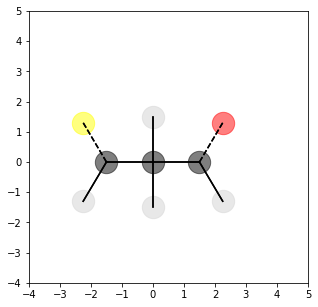

In [98]:
# test of kernel with L

from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
from torch_geometric.utils import degree

import torch
from torch.nn import ModuleList
from torch.nn import CosineSimilarity, Module, ModuleList, Linear, Sigmoid
from torch.nn.parameter import Parameter

from itertools import permutations
import math


class KernelConv(Module):
    def __init__(self, L=None, D=None, num_supports=None, node_attr_dim=None, edge_attr_dim=None, init_kernel: 'type(Data)'=None):
        super(KernelConv, self).__init__()
        if init_kernel is None:
            if (L is None) or (D is None) or (num_supports is None) or (node_attr_dim is None) or (edge_attr_dim is None):
                raise Exception(
                    'either numer of kernels L, convolution dimention D, number of support num_supports or feature dimension node_attr_dim is not specified')
            else:
                init_kernel = Data(x_center=torch.randn(L, 1, node_attr_dim),  x_support=torch.randn(
                    L, num_supports, node_attr_dim), edge_attr_support=torch.randn(L, num_supports, edge_attr_dim), p_support=torch.randn(L, num_supports, D))

        x_center_tensor = init_kernel.x_center
        self.x_center = Parameter(x_center_tensor)

        x_support_tensor = init_kernel.x_support
        self.x_support = Parameter(x_support_tensor)

        edge_attr_support_tensor = init_kernel.edge_attr_support
        self.edge_attr_support = Parameter(edge_attr_support_tensor)

        p_support_tensor = init_kernel.p_support
#         print(f'p_support_tensor:{p_support_tensor.shape}')
        self.p_support = Parameter(p_support_tensor)

    def permute(self, x):
        #         print('permute')
        #         print('x')
        #         print(x.shape)
        rows = x.shape[1]
        l = [x[:, torch.tensor(permute), :]
             for permute in list(permutations(range(rows)))]
        output = torch.stack(l, dim=1)
#         print('permuted')
#         print(output.shape)
        return output

    def intra_angle(self, p):
        '''
        angles between each row vectors
        '''
        cos = CosineSimilarity(dim=-1)
        new_p = torch.roll(p, 1, dims=-2)
#         print(f'new p:')
#         print(new_p)
        sc = cos(new_p, p)
#         print(f'intra angle sc:{sc.shape}')
        return sc

    def arctan_sc(self, tensor1, tensor2, dim=None):
        diff = torch.square(tensor1 - tensor2)
#         print(diff)
        if dim is not None:
            sc = torch.sum(diff, dim=dim)
        else:
            sc = torch.sum(diff)
        sc = torch.atan(1 / sc)
        return sc

    def get_angle_score(self, p_neighbor, p_support):
        print('get_angle_score')
        print(f'p_neighbor:{p_neighbor.shape}')
        #         print(p_neighbor.shape)
        print(f'p_support:{p_support.shape}')
        #         print(p_support.shape)
        if(p_support.shape[-2] == 1):
            return torch.full((p_support.shape[0], p_neighbor.shape[0]), math.pi / 2)
#         cos = CosineSimilarity(dim = 1)

        p_neighbor = p_neighbor.unsqueeze(0).unsqueeze(0).expand(
            p_support.shape[0], p_support.shape[1], p_neighbor.shape[-3], p_neighbor.shape[-2], p_neighbor.shape[-1])
#         p_neighbor = p_neighbor.unsqueeze(0).expand(p_support.shape)
#         print(f'p_neighbor:{p_neighbor.shape}')
        intra_p_neighbor_angle = self.intra_angle(p_neighbor)
#         intra_p_neighbor_dist = intra_p_neighbor_dist.unsqueeze(0).expand(p_support.shape[0], p_neighbor.shape[0],p_neighbor.shape[1])
#         print(f'intra_p_neighbor_dist:{intra_p_neighbor_dist.shape}')

#         p_support = p_support.expand(p_neighbor.shape)
#         print(f'p_support:{p_support.shape}')
        intra_p_support_angle = self.intra_angle(p_support)
#         intra_p_support_dist = intra_p_support_dist.unsqueeze(1).expand(p_support.shape[0], p_neighbor.shape[0],p_support.shape[1])
#         print(f'intra_p_support_dist:{intra_p_support_dist.shape}')

#         sc = cos(intra_p_neighbor_dist, intra_p_support_dist)
#         sc = torch.dot(intra_p_neighbor_dist, intra_p_support_dist.T)
        sc = self.arctan_sc(intra_p_neighbor_angle,
                            intra_p_support_angle, dim=(-1))
        print(f'inner angle_sc:{sc.shape}')
        return sc.squeeze(1)

    def get_length_score(self, p_neighbor, p_support):
        len_p_neighbor = torch.norm(p_neighbor, dim=-1)
        len_p_support = torch.norm(p_support, dim=-1)

#         print('len_p_neighbor')
#         print(f'len_p_neighbor:{len_p_neighbor.shape}')
#         print(f'len_p_support:{len_p_support.shape}')

        # inverse of L2 norm
        sc = self.arctan_sc(len_p_neighbor, len_p_support, dim=(-1))
#         diff = torch.square(len_p_neighbor - len_p_support)
#         sc = torch.sum(diff)
#         sc = torch.atan(1/sc)

# #         print(sc)
        return sc

    def get_support_attribute_score(self, x_nei, x_support):
#         print(f'x_nei:{x_nei.shape}')
#         print(f'x_suppport:{x_support.shape}')
        x_nei = x_nei.unsqueeze(0).unsqueeze(0).expand(x_support.shape[0], x_support.shape[1], x_nei.shape[0], x_nei.shape[1], x_nei.shape[2])
        x_support = x_support.unsqueeze(2).expand(x_nei.shape)

        
        sc = self.arctan_sc(x_nei, x_support, dim=(-2, -1))
        return sc

    def get_center_attribute_score(self, x_focal, x_center):
        # inverse of L2 norm
        #         print(f'center attri:{type(x_focal)}, {type(x_center)}')
        #         print(f'x_focal:{x_focal.shape}, x_center:{x_center.shape}')
        #         print(x_focal)
        #         print(x_center)
        #         diff = torch.square(x_focal - x_center)
        #         sc = torch.sum(diff)
        #         sc:'shape([])' = torch.atan(1/sc)
        x_focal = x_focal.unsqueeze(0).expand(
            x_center.shape[0], x_focal.shape[0], x_focal.shape[1])
        x_center = x_center.expand(x_focal.shape)
#         print('x_focal')
#         print(x_focal)
#         print('x_center')
#         print(x_center)
        
        sc = self.arctan_sc(x_focal, x_center, dim=(-1))
        return sc

    def get_edge_attribute_score(self, edge_attr_nei, edge_attr_support):
        #         print('edge_attr_nei')
        #         print(edge_attr_nei)
        #         print('edge_attr_support')
        #         print(edge_attr_support)
        #         diff = torch.square(edge_attr_nei - edge_attr_support)
        #         sc = torch.sum(diff)
        #         sc:'shape([])' = torch.atan(1/sc)
        sc = self.arctan_sc(edge_attr_nei, edge_attr_support, dim=( -2, -1))
        return sc

    def calculate_total_score(self, x_focal, p_focal, x_neighbor, p_neighbor, edge_attr_neighbor):
        # calibrate p_neighbor
        p_neighbor = p_neighbor - p_focal.unsqueeze(1)

        # get kernel params
        x_center = self.x_center
        x_support = self.x_support
        edge_attr_support = self.edge_attr_support
        p_support = self.p_support

#         print('=====cal total sc')
#         print(f'x_center:{x_center.shape}')
#         print(f'x_support:{x_support.shape}')
#         print(f'edge_attr_support:{edge_attr_support.shape}')
#         print(f'p_support:{p_support.shape}')
#         print('\n')
#         print(f'x_focal:{x_focal.shape}')
#         print(f'p_focal:{p_focal.shape}')
#         print(f'x_neighbor:{x_neighbor.shape}')
#         print(f'p_neighbor:{p_neighbor.shape}')
#         print(f'edge_attr_neighbor:{edge_attr_neighbor.shape}')

        # calculate the support attribute score
        permuted_x_support = self.permute(x_support)
#         print(f'permuted_x_support:{permuted_x_support.shape}')
        support_attr_sc = self.get_support_attribute_score(x_neighbor, permuted_x_support)
#         print(f'support_attr_sc:{support_attr_sc}')
        # get the best support_attr_sc and its index
        best_support_attr_sc, best_support_attr_sc_index = torch.max(support_attr_sc, dim=1)
#         print(f'best_support_attr_sc:{best_support_attr_sc}, index:{best_support_attr_sc_index.shape}')
#         print(f'index:{best_support_attr_sc_index}')
        
        
        # calculate the angle score
        permuted_p_support = self.permute(p_support)
        permuted_p_support = permuted_p_support.unsqueeze(2).expand(permuted_p_support.shape[0], permuted_p_support.shape[1], best_support_attr_sc_index.shape[1], permuted_p_support.shape[2], permuted_p_support.shape[3])
#         print(f'permuted_p_support:{permuted_p_support}')
        selected_index = best_support_attr_sc_index.unsqueeze(1).unsqueeze(-1).unsqueeze(-1).expand(
            permuted_p_support.shape[0], 1, best_support_attr_sc_index.shape[-1], permuted_p_support.shape[3], permuted_p_support.shape[4])
        best_p_support = torch.gather(permuted_p_support, 1, selected_index)
#         print(f'best_p_support:{best_p_support}')
        angle_sc = self.get_angle_score(p_neighbor, best_p_support)
        print(f'angle_sc:{angle_sc}')
        
        
        # calculate length
        best_p_support = best_p_support.squeeze(1)
#         print(f'best_p_support:{best_p_support.shape}')
        length_sc = self.get_length_score(p_neighbor, best_p_support)
#         print(f'length_sc:{length_sc.shape}')        
        
   
        # calculate the center attribute score
#         print(f'x_center:{x_center.shape}')
        center_attr_sc = self.get_center_attribute_score(x_focal, x_center)
#         print(f'center_attr_sc:{center_attr_sc.shape}')

        
        # calculate the edge attribute score
        selected_index = best_support_attr_sc_index.unsqueeze(-1).unsqueeze(-1).expand(best_support_attr_sc_index.shape[0], best_support_attr_sc_index.shape[1], edge_attr_support.shape[-2], edge_attr_support.shape[-1])
#         print(f'edge_attr_support:{edge_attr_support.shape}')
        permuted_edge_attr_support = self.permute(edge_attr_support)
#         print(f'permuted:{permuted_edge_attr_support.shape}')
#         print(f'best_angle_sc_index:{best_angle_sc_index.shape}')
        best_edge_attr_support = torch.gather(
            permuted_edge_attr_support, 1, selected_index)
#         print(f'best_edge_attr_support:{selected_index.shape}')
#         print(f'edge_attr_neighbor:{edge_attr_neighbor.shape}')
#         print(f'best_edge_attr_support:{best_edge_attr_support.shape}')
        edge_attr_support_sc = self.get_edge_attribute_score(
            edge_attr_neighbor, best_edge_attr_support)
#         print(f'edge_attr_support_sc:{edge_attr_support_sc.shape}')
        
        

#         # convert each score to correct dimension
#         angle_sc = angle_sc
#         length_sc = length_sc
        support_attr_sc = best_support_attr_sc#.unsqueeze(dim=0)
#         center_attr_sc = center_attr_sc
#         edge_attr_support_sc = edge_attr_support_sc

        # the maxium value a arctain function can get
        max_atan = torch.tensor([math.pi / 2])
        one = torch.tensor([1])

        sc = torch.atan(1 /
                        (torch.square(length_sc - max_atan) +
                         torch.square(angle_sc - max_atan) +
                         torch.square(support_attr_sc - max_atan) +
                         torch.square(center_attr_sc - max_atan) +
                         torch.square(edge_attr_support_sc - max_atan)
                         )).squeeze(0)
#         print(f'cal total sc:{sc}')

        return sc, length_sc, angle_sc, support_attr_sc, center_attr_sc, edge_attr_support_sc

    def forward(self, *argv, **kwargv):
        if len(kwargv) == 1:
            x_focal = kwargv['data'].x_focal
            p_focal = kwargv['data'].p_focal
            x_neighbor = kwargv['data'].x_neighbor
            p_neighbor = kwargv['data'].p_neighbor
            edge_attr_neighbor = kwargv['data'].edge_attr_neighbor
        else:
            x_focal = kwargv['x_focal']
            p_focal = kwargv['p_focal']
            x_neighbor = kwargv['x_neighbor']
            p_neighbor = kwargv['p_neighbor']
            edge_attr_neighbor = kwargv['edge_attr_neighbor']


#         x, x_focal, p, edge_attr, edge_index = self.convert_graph_to_receptive_field(x, p, edge_index, edge_attr)

        sc, length_sc, angle_sc, supp_attr_sc, center_attr_sc, edge_attr_support_sc = self.calculate_total_score(
            x_focal, p_focal, x_neighbor, p_neighbor, edge_attr_neighbor)


#         print('\n')
        print(f'len sc:{length_sc.shape}')
        print(f'angle sc:{angle_sc.shape}')
        print(f'support attribute_sc:{supp_attr_sc.shape}')
        print(f'center_attr_sc:{center_attr_sc.shape}')
        print(f'edge attribute score:{edge_attr_support_sc.shape}')
        print(f'total sc: {sc.shape}')
        return sc  # , length_sc, angle_sc, supp_attr_sc, center_attr_sc, edge_attr_support_sc


class KernelSetConv(Module):
    def __init__(self, L, D, node_attr_dim, edge_attr_dim):
        super(KernelSetConv, self).__init__()
        self.L = L
        
# test of std kernel 
        p_support = torch.tensor([[ 1.2990e+00,  7.5000e-01]]).unsqueeze(0)
        print(p_support)


        x_center = torch.tensor([[16, 32.067, 1.8, 2, 6]]).unsqueeze(0)


        x_support = torch.tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]]).unsqueeze(0)

        edge_attr_support = torch.tensor([[2]], dtype = torch.float).unsqueeze(0)
        
        
        kernel1_std = Data(p_support = p_support, x_support = x_support, x_center = x_center, edge_attr_support = edge_attr_support)



        p_support = torch.tensor([[ 1.2990e+00,  7.5000e-01],
        [-1.2990e+00,  7.5000e-01],
        [-2.7756e-16, -1.5000e+00]]).unsqueeze(0)
        print(p_support)


        x_support = torch.tensor([[16, 32.067, 1.8, 2, 6],
        [  6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]]).unsqueeze(0)


        x_center = torch.tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]]).unsqueeze(0)

        edge_attr_support = torch.tensor([[2],[1],[1]], dtype = torch.float).unsqueeze(0)
        
        
        kernel3_std = Data(p_support = p_support, x_support = x_support, x_center = x_center, edge_attr_support = edge_attr_support)
                           
#         kernel1 = KernelConv(init_kernel = kernel1_std)                   
        kernel1 = KernelConv(L=L, D=D, num_supports=1, node_attr_dim=node_attr_dim, edge_attr_dim=edge_attr_dim)
        kernel2 = KernelConv(L=L, D=D, num_supports=2, node_attr_dim=node_attr_dim, edge_attr_dim=edge_attr_dim)
                             
#         kernel3 = KernelConv(init_kernel = kernel3_std) 
        kernel3 = KernelConv(L=L, D=D, num_supports=3,node_attr_dim=node_attr_dim, edge_attr_dim=edge_attr_dim)
        kernel4 = KernelConv(L=L, D=D, num_supports=4,node_attr_dim=node_attr_dim, edge_attr_dim=edge_attr_dim)

        self.kernel_set = ModuleList([kernel1, kernel2, kernel3, kernel4])

#         kernel_set = ModuleList(
#             [KernelConv(D=D, num_supports=1, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim),
#              KernelConv(D=D, num_supports=2, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim),
#              KernelConv(D=D, num_supports=3, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim),
#              KernelConv(D=D, num_supports=4, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim)
#             ])

    def get_degree_index(self, x, edge_index):
        deg = degree(edge_index[0], x.shape[0])
        return deg

    def get_neighbor_index(self, edge_index, center_index):
        #         print('edge_index')
        #         print(edge_index)
        #         print('\n')
        #         print('center_index')
        #         print(center_index)
        a = edge_index[0]
        b = a.unsqueeze(1) == center_index
        c = b.nonzero()
        d = c[:, 0]
        return edge_index[1, d]

    def get_focal_nodes_of_degree(self, deg, x, p, edge_index):
        '''
        outputs
        ori_x: a feature matrix that only contains rows (i.e. the center node) having certain degree
        ori_p: a position matrix that only contains rows (i.e. the center node) having certain degree
        '''
        deg_index = self.get_degree_index(x, edge_index)
        selected_index = (deg_index == deg).nonzero(as_tuple=True)
        x_focal = torch.index_select(input=x, dim=0, index=selected_index[0])
        p_focal = torch.index_select(input=p, dim=0, index=selected_index[0])

        return x_focal, p_focal, selected_index[0]

    def get_edge_attr_support_from_center_node(self, edge_attr, edge_index, center_index):
        a = edge_index[0]
        b = a.unsqueeze(1) == center_index
        c = b.nonzero()
        d = c[:, 0]

        # normalize bond id
        e = (d / 2).long()
#         bond_id = torch.cat([torch.stack((2*x, 2*x+1)) for x in e])
        bond_id = torch.tensor([2 * x for x in e])
#         print('bond_id')
#         print(bond_id)

        # select bond attributes with the bond id
        nei_edge_attr = torch.index_select(
            input=edge_attr, dim=0, index=bond_id)

        return nei_edge_attr

    def get_neighbor_nodes_and_edges_of_degree(self, deg, x, p, edge_index, edge_attr):
        '''
        inputs:
        deg: the query degree
        num_focal: the number of focal nodes of degree deg in the graph

        outputs:
        nei_x: a feature matrix that only contains rows (i.e. the neighboring node) that its center node has certain degree
        nei_p: a position matrix that only contains rows (i.e. the neighboring node) that its center node has certain degree
        '''
        deg_index = self.get_degree_index(x, edge_index)
        center_index = (deg_index == deg).nonzero(as_tuple=True)[0]
        num_focal = len(center_index)
#         print('center_index')
#         print(center_index)

        nei_x_list = []
        nei_p_list = []
        nei_edge_attr_list = []
        for i in range(num_focal):
            nei_index = self.get_neighbor_index(edge_index, center_index[i])
#             print(f'nei_index:{nei_index.shape}')

            nei_x = torch.index_select(x, 0, nei_index)
#             print(f'nei_x:{nei_x.shape}')
            nei_p = torch.index_select(p, 0, nei_index)
#             print(f'nei_p:{nei_p.shape}')
            nei_edge_attr = self.get_edge_attr_support_from_center_node(
                edge_attr, edge_index, center_index[i])
#             print('\n nei_edge_attr')
#             print(nei_edge_attr)

            nei_x_list.append(nei_x)
            nei_p_list.append(nei_p)
            nei_edge_attr_list.append(nei_edge_attr)

        nei_x = torch.stack(nei_x_list, dim=0)
        nei_p = torch.stack(nei_p_list, dim=0)
        nei_edge_attr: 'shape(num_focal, num_support*2, num_support_attr_dim)' = torch.stack(
            nei_edge_attr_list, dim=0)

#         print('nei_edge_attr')
#         print(nei_edge_attr.shape)

        return nei_x, nei_p, nei_edge_attr

    def convert_graph_to_receptive_field(self, deg, x, p, edge_index, edge_attr):
        x_focal, p_focal, selected_index = self.get_focal_nodes_of_degree(
            deg=deg, x=x, p=p, edge_index=edge_index)

        num_focal = x_focal.shape[0]
        print(f'num_focal:{num_focal}')
        if num_focal != 0:
            x_neighbor, p_neighbor, edge_attr_neighbor = self.get_neighbor_nodes_and_edges_of_degree(
                deg=deg, x=x, edge_index=edge_index, p=p, edge_attr=edge_attr)
#             print(f'x_neighbor:{x_neighbor.shape}')
#             print(f'p_neighbor:{p_neighbor.shape}')
            return x_focal, p_focal, x_neighbor, p_neighbor, edge_attr_neighbor, selected_index
        return None
    def get_reorder_index(self, index):
        '''
        get the index to rearrange output score matrix so that it corespond to the order in the original x matrix
        
        '''
        rearranged, new_index = torch.sort(index, dim = 0)
   
        return new_index

    def format_output(self, output):
        '''
        change the shape of output from (L, num_nodes, 4) to (num_nodes, 4*L)
        '''
        a = [output[i, :, :] for i in range(output.shape[0])]
        return torch.cat(a, dim =1)

    def forward(self, *argv, **kwargv):
        '''
        inputs:
        data: graph data containing feature matrix, adjacency matrix, edge_attr matrix
        '''
        if len(argv) != 0:
            raise Exception(
                'Kernel does not take positional argument, use keyword argument instead. e.g. model(data=data)')

        if len(kwargv) == 1:
            x = kwargv['data'].x
            edge_index = kwargv['data'].edge_index
            edge_attr = kwargv['data'].edge_attr
            p = kwargv['data'].p

        else:
            x = kwargv['x']
            edge_index = kwargv['edge_index']
            edge_attr = kwargv['edge_attr']
            p = kwargv['p']

#         print('edge_index')
#         print(edge_index)

#         print('edge_attr')
#         print(edge_attr)

        # loop through all possbile degrees. i.e. 1 to 4 bonds
        sc_list = []
        index_list = []
        for deg in range(1, 5):
            print(f'deg:{deg}')
            receptive_field = self.convert_graph_to_receptive_field(
                deg, x, p, edge_index, edge_attr)
#             print('receptive_field')
#             print(receptive_field)
            if receptive_field is not None:
                x_focal, p_focal, x_neighbor, p_neighbor, edge_attr_neighbor, selected_index = receptive_field[
                    0], receptive_field[1], receptive_field[2], receptive_field[3], receptive_field[4],  receptive_field[5]
                data = Data(x_focal=x_focal, p_focal=p_focal, x_neighbor=x_neighbor,
                            p_neighbor=p_neighbor, edge_attr_neighbor=edge_attr_neighbor)
                
                print(f'selected_index:{selected_index.shape}')
#                 print('====data info====')
#                 print('x_focal')
#                 print(x_focal.shape)
#             print('p_focal')
#             print(p_focal)
#             print('x_neighbor')
#             print(x_neighbor)
#             print('p_neighbor')
#             print(p_neighbor)
#             print('edge_attr_neighbor')
#             print(edge_attr_neighbor)
                sc = self.kernel_set[deg - 1](data=data)
#                 print(f'sc.shape:{sc.shape}')
                zeros = torch.zeros(self.L, x_focal.shape[0], 4)
                zeros[:,:,deg-1] = sc
                sc = zeros
                print(f'sc:{sc.shape}')
                sc_list.append(sc)
                index_list.append(selected_index)

            else:
#                 sc = torch.tensor([0] * self.L)
                # the maxium value a arctain function can get
#                 max_atan = torch.tensor([math.pi / 2] * self.L)
#                 sc = max_atan
#                 sc = torch.zeros(self.L, x_focal.shape[0], 4)
                pass
            
    
        
        sc_list = torch.cat(sc_list, dim = 1)
        print(index_list)
        index_list = torch.cat(index_list)
#         print(f'sc_list:{sc_list}')
        new_index = self.get_reorder_index(index_list) 
        sc_list = sc_list[:,new_index,:]
        sc_list = self.format_output(sc_list)
        print(sc_list.shape)
        
        return sc_list


class KernelLayer(Module):
    def __init__(self, x_dim, p_dim, edge_dim, out_dim):
        '''
        a wrapper of KernelSetConv for clear input/output dimension
        inputs:
        D: dimension
        L: number of KernelConvSet
        '''
        super(KernelLayer, self).__init__()
        self.conv = KernelSetConv(
            L=out_dim, D=p_dim, node_attr_dim=x_dim, edge_attr_dim=edge_dim)

    def forward(self, data):
        return self.conv(data=data)
    
smiles = 'C(C(C=O)([H])[H])=S'
x, p, edge_index, edge_attr = smiles2graph(2, smiles)
data = Data(x = x, p = p, edge_index = edge_index, edge_attr = edge_attr)
print(data)    
vis_graph(data)


model = KernelLayer(x_dim = 5, p_dim = 2, edge_dim = 1, out_dim = 2)
out = model(data=data)
print(out)


In [77]:
a = torch.randn(2, 9, 4)
print(a)


b = [a[i, :, :] for i in range(a.shape[0])]

c = torch. cat(b, dim =1)
print(c.shape)
print(c)

tensor([[[ 0.5989,  1.8609, -0.9525, -0.4336],
         [ 0.3139,  1.2988,  0.1364,  1.1438],
         [-1.6333, -1.0214,  0.8863,  0.2215],
         [-1.2760,  2.2263, -2.1162, -0.0910],
         [-0.0887,  0.0986, -0.7341,  2.3343],
         [ 0.6210,  1.2802, -1.0199, -0.6598],
         [-0.3677, -0.5897,  1.3464,  0.4830],
         [-0.9407,  0.1645, -0.9641,  0.8379],
         [ 1.6808, -0.0058,  1.3512,  1.1819]],

        [[-1.2387,  0.1193, -0.4016, -0.7574],
         [-0.5186, -0.3816, -1.0360,  0.7144],
         [-1.2038,  0.0486, -0.5772,  0.7299],
         [-0.6319, -1.8152, -0.2592, -1.8061],
         [ 0.3801,  0.8646, -0.6438,  0.7937],
         [ 0.8977,  0.4679, -0.3002, -0.8785],
         [-1.2359, -1.1736, -1.6003,  1.7186],
         [-1.6731, -1.4959,  0.1438, -1.2760],
         [-0.9401,  2.2204, -1.3531, -0.9290]]])
torch.Size([9, 8])
tensor([[ 0.5989,  1.8609, -0.9525, -0.4336, -1.2387,  0.1193, -0.4016, -0.7574],
        [ 0.3139,  1.2988,  0.1364,  1.1438, -0.5

In [ ]:
import torch
from torch.nn import ModuleList
from torch_geometric.nn import MessagePassing
# from kernels import KernelLayer

class MolGCN(MessagePassing):
    def __init__(self, num_layers, num_kernel_layers, x_dim, p_dim, edge_attr_dim):
        super(MolGCN, self).__init__()
        self.num_layers = num_layers
        if num_layers <1:
            raise Exception('at least one convolution layer is needed')

        self.layers = ModuleList()
        kernel_layer = KernelLayer(x_dim, p_dim, edge_attr_dim, num_kernel_layers)
        self.layers.append(kernel_layer)
        x_dim = num_kernel_layers *4 
        for i in range(num_layers-1):
            kernel_layer = KernelLayer(x_dim, p_dim, edge_attr_dim, num_kernel_layers)
            layers.append(kernel_layer)

            
    def get_degree_index(self, x, edge_index):
        deg = degree(edge_index[0], x.shape[0])
        return deg            
            
    def forward(self, *argv, **kwargv):
        if len(argv)!=0:
            raise Exception('Kernel does not take positional argument, use keyword argument instead. e.g. model(data=data)')
        
        if len(kwargv) == 1:
            x = kwargv['data'].x
            edge_index = kwargv['data'].edge_index
            edge_attr = kwargv['data'].edge_attr
            p = kwargv['data'].p
          
        else:
            x = kwargv['x']
            edge_index = kwargv['edge_index']
            edge_attr = kwargv['edge_attr']
            p = kwargv['p']        
        
        print(edge_index)
        
        kernel_layer = self.layers[0]
        
        x = self.propagate(edge_index, x=x)
        
        for i in range(1, self.num_layers-1):
            hidden_data = torch.clone(data)
            hidden_data.x = torch.flatten(h)
            kernel_layer = self.layers[i]
            self.propagate(edge_index, x, kernel_layer)


    def message(self, x_j):
        return x_j
        
        
# # data
# smiles = 'C(C(C=O)([H])[H])=S'
# x, p, edge_index, edge_attr = smiles2graph(2, smiles)
# data = Data(x = x, p = p, edge_index = edge_index, edge_attr = edge_attr)
# print(data)    
# vis_graph(data)
        
# # model
# model = MolGCN(num_layers = 1, num_kernel_layers = 5, x_dim = 5, p_dim =2, edge_attr_dim = 1)
# model(data = data)

In [ ]:
# standard kernels


#==================standard kernel===================
# # S = 3
# S = 3
# x_center = torch.tensor([[1]], dtype = torch.float)
# x_support = torch.tensor([[1],[1],[1]], dtype = torch.float)
# p_support = torch.tensor([[1,0],[-math.sqrt(0.5),-math.sqrt(0.5)],[0,1]], dtype = torch.float)

# # # S = 4
# # # kernel
# # S = 4
# # x_center = torch.tensor([[1]], dtype = torch.float)
# # x_support = torch.tensor([[1],[1],[1]], dtype = torch.float)
# # p_support = torch.tensor([[1,0],[-math.sqrt(0.5),-math.sqrt(0.5)],[0,1], [math.sqrt(0.5), -math.sqrt(0.5)]], dtype = torch.float)
#======================================================

s =3

h_list = []
for i in range(s):
    h = get_atom_rep(8, 'rdkit')
    h_list.append(h)
x_support = torch.tensor(h_list)

p_support = torch.randn(s, 2)

x_center = torch.tensor(get_atom_rep(16, 'rdkit'))

edge_attr_support = torch.randn(3)

init_kernel = Data(x_center = x_center, x_support = x_support, p_support=p_support, edge_attr_support = edge_attr_support)



In [ ]:
# reset kernel

# data prep
smiles = 'C(C(C=O)([H])[H])=S'
x, p, edge_index, edge_attr = smiles2graph(2, smiles)
data = Data(x = x, p = p, edge_index = edge_index, edge_attr = edge_attr)
# print_data(data)

# manual data for weird angle testing
trans = torch.tensor([[1,1]])
# x= torch.tensor([[1],[1],[1],[1],[1],[1]], dtype = torch.float)
x= torch.tensor([[1],[1],[1],[1],[1]], dtype = torch.float)
# p= torch.tensor([[-1,0],[-math.sqrt(0.5),math.sqrt(0.5)],[0,1], [0,0], [math.sqrt(0.5), 1+math.sqrt(0.5)], [0,3]], dtype = torch.float)
p= torch.tensor([[-1,0],[-math.sqrt(0.5),math.sqrt(0.5)],[0,1],[0,0],[0,2]])#, [math.sqrt(0.5), 1+math.sqrt(0.5)], [0,3]], dtype = torch.float)
p+=trans
# edge_index = torch.tensor([[0,3,1,3,2,3, 5,2,2,4],[3,0,3,1,3,2,2,5,4,2]])
edge_index = torch.tensor([[0,3,1,3,2,3, 4,2],[3,0,3,1,3,2,2,4]])
# edge_attr = torch.tensor([[1],[1],[1],[1],[1],[1],[1],[1],[1],[1]])
edge_attr = torch.tensor([[1],[1],[1],[1],[1],[1],[1],[1]])
data = Data(x = x, p = p, edge_index = edge_index, edge_attr = edge_attr)

# ========generate a list of graphs
origin = torch.tensor([0,0])
vis_graph(data)
data_list = []
for i in range(0, 370, 10):
    data = graph_rotate(data, origin, i)
    data_list.append(data)
#     vis_graph(data)


# model prep
node_attr_dim = x.shape[1]
edge_attr_dim = edge_attr.shape[1]
model = KernelSetConv(L=10, D=2, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim)


# examine the model kernel
# x_center = model.state_dict()['kernel_set.2.x_center']
# x_support = model.state_dict()['kernel_set.2.x_support']
# edge_attr_support = model.state_dict()['kernel_set.2.edge_attr_support']
# p_support = model.state_dict()['kernel_set.2.p_support']
# m_kernel = Data(x_center= x_center, x_support = x_support, edge_attr_support = edge_attr_support, p_support = p_support)
# vis_kernel(m_kernel) # this visualize one single kernel
# # vis_kernel_in_model(model) # this visualize all kernels in the model


# run
# model(data = data)


# KernelConv test

In [ ]:
# training with attributed data
from torch.optim import Adam
from torch.nn import MSELoss, CrossEntropyLoss
import random
from tqdm import tqdm

torch.set_printoptions(precision=6)
random.seed(None)
optimizer = Adam(model.parameters(), lr=0.5)  # Define optimizer.

# Loss func selection
criterion = MSELoss()
# criterion = CosineSimilarity(dim = 0)
# criterion = CrossEngropyLoss


def train():
    random.shuffle(data_list)
    for data in data_list:
#         vis_graph(data)
#         sc, length_sc, angle_sc, supp_attr_sc, center_attr_sc, edge_attr_support_sc = model(data=data)
        sc = model(data=data)
        label = torch.tensor([math.pi/2], dtype= torch.float)
        loss = criterion(sc, label)
        optimizer.zero_grad()
        
#         print('before')
#         params = model.state_dict()
#         for param in params:
#             print(f'{param}:{params[param]}')
            
        loss.backward()
        optimizer.step()
        
#         print('after')
#         params = model.state_dict()
#         for param in params:
#             print(f'{param}:{params[param]}')
        
    print('\n')
    print(f'loss:{loss.item()}')
#     print(f'len sc:{length_sc.item()}')
#     print(f'angle sc:{angle_sc.item()}')
#     print(f'support attribute_sc:{supp_attr_sc.item()}')
#     print(f'edge attribute score:{edge_attr_support_sc.item()}')
    print(f'label:{label}')
    print(f'total sc: {sc}')    

for i in range(20):
    print(f'========epoch {i}========')
    train()
    
    # turn on this to visulize each step
#     params = model.parameters()
#     param = list(params)[0].detach().numpy()
#     vis(param, p_support_origin)
    


In [ ]:
vis_kernel_in_model(model)

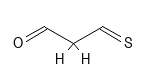
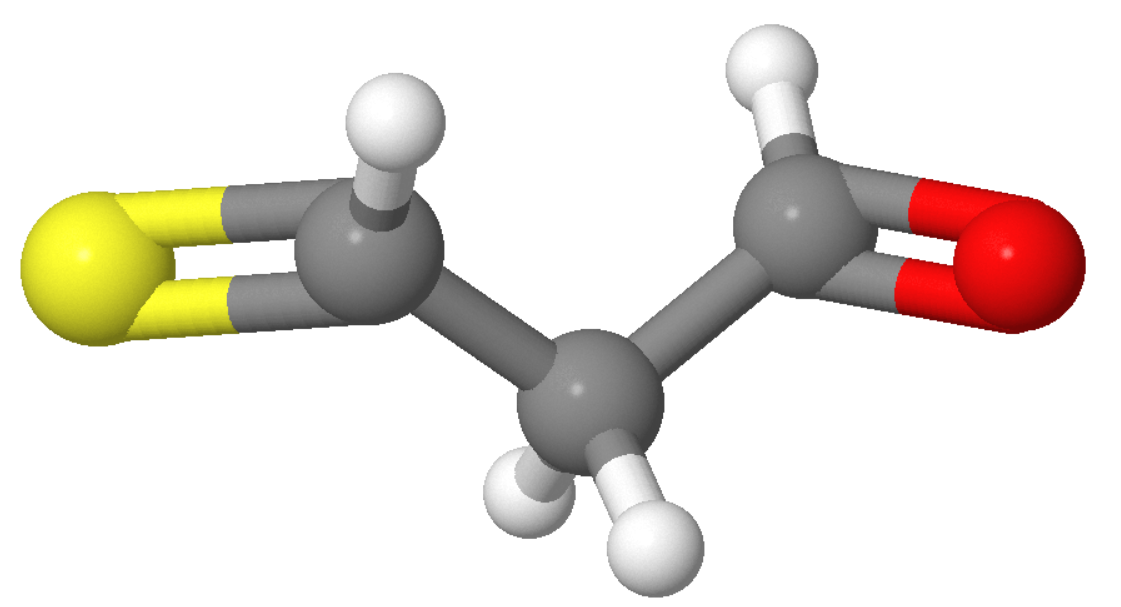

In [ ]:
# test of getting neighbor_index from center_index
import torch
# tensor = torch.randint(15,(2,4), dtype=torch.long)
# print('tensor:')
# print(tensor)

# print('\n')
# print('values')
# values = torch.arange(10, dtype=torch.long)
# print(values)

# print('\n')
# a = tensor[0]

# print(a)
# b = a.unsqueeze(1) == values
# print(b)
# c = b.nonzero()
# print(c)
# d = c[:,0]
# print(d)
# tensor[1,d]


def get_neighbor_index(edge_index, center_index):
    a = edge_index[0]
    b = a.unsqueeze(1) == center_index
    c = b.nonzero()
    d = c[:,0]
    
    return edge_index[1,d]

a = get_neighbor_index(tensor, values)

# print(f'a:{a}')

edge_index = torch.tensor([[0, 1, 1, 2, 2, 3, 0, 4, 0, 5, 1, 6, 1, 7, 2, 8], [1, 0, 2, 1, 3, 2, 4, 0, 5, 0, 6, 1, 7, 1, 8, 2]])
print(edge_index)
nei_index = torch.tensor([1,3,8])
print(nei_index)
edge_attr = torch.tensor([[1],
        [1],
        [1],
        [1],
        [2],
        [2],
        [2],
        [2],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])

def get_edge_attr_support_from_center_node(edge_attr, edge_index, center_index):
    a = edge_index[0]
    b = a.unsqueeze(1) == center_index
    c = b.nonzero()
    d = c[:,0]

    # normalize bond id
    e = (d/2).long()
    bond_id = torch.cat([torch.stack((2*x, 2*x+1)) for x in e])
    
    # select bond attributes with the bond id
    nei_edge_attr = torch.index_select(input = edge_attr, dim = 0, index = bond_id)
    
    return nei_edge_attr
center_index = torch.tensor([2])

a = get_edge_attr_support_from_center_node(edge_attr, edge_index, center_index)
print(a)

In [ ]:
# test of selecting index
def permute(x):
    #         print('permute')
    #         print('x')
    #         print(x.shape)
    rows = x.shape[1]
    l = [x[:, torch.tensor(permute), :]
         for permute in list(permutations(range(rows)))]
    output = torch.stack(l, dim=1)
#         print('permuted')
#         print(output.shape)
    return output

a = torch.randn(4, 3,2)
a = permute(a)
b = torch.randint(6, (4,2)) 
a=a.unsqueeze(2).expand(a.shape[0], a.shape[1], b.shape[1], a.shape[2], a.shape[3])
print(f'a.shape:{a.shape}')
print(a)

b = b.unsqueeze(1).unsqueeze(-1).unsqueeze(-1).expand(a.shape[0], 1, b.shape[-1], a.shape[3], a.shape[4])
print(f'b.shape:{b.shape}')
print(b)
c =torch.gather(a, 1, b)
print(c)
print(c.shape)